In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

['train', 'test']


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1.  EDA
SO, how to load the dataset???

```cd /kaggle/input/train``` / ```cd /kaggle/input/test```, jpg images are saved in this path

In [29]:
train_path = '/kaggle/input/train/'
test_path = '/kaggle/input/test/'

In [30]:
print(os.path.exists(train_path), os.path.exists(test_path))

True True


In [31]:
train_images = [train_path+i for i in os.listdir(train_path)]
train_cat = [i for i in train_images if 'cat' in i]
train_dog = [i for i in train_images if 'dog' in i]
print('On train set \ncat:',len(train_cat), '\ndog:',len(train_dog))
test_images = [test_path+i for i in os.listdir(test_path)]

On train set 
cat: 12500 
dog: 12500


In [32]:
labels= []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else: labels.append(0)

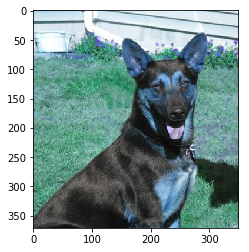

In [33]:
img = cv2.imread(train_images[1])
plt.imshow(img)

#  2. Read and process image

```np.expand_dims()```-> [Numpy知识点补充：np.expand_dims()&np.argmax()]**(https://www.jianshu.com/p/da10840660cb)

In [34]:
def read_and_process_image(width=64, height=64, channels=3, preprocess=False):
    train_images = ['/kaggle/input/train/'+i for i in os.listdir('/kaggle/input/train/')]
    random.shuffle(train_images)
    
    def read_image(file_path, preprocess):
        img = image.load_img(file_path, target_size=(height,width)) # read and resize to target_size
        x = image.img_to_array(img) # to numpy array by using keras.preprocessing.image
        x = np.expand_dims(x, axis=0) # x.shape(2,2,2) -> x.shape(1,2,2,2)
        if preprocess:     # 对于VGG模型，图片需要每个颜色通道减去每个通道的平均值
            x = preprocess_input(x) # keras.applications.vgg16.preprocess_input
        return x
    
    def prep_data(images, preprocess):
        count = len(images)
        data = np.ndarray((count, height, width, channels), dtype=np.float32)
        for i, img_file in enumerate(images):
            image = read_image(img_file, preprocess)
            data[i] = image
        return data
    
    def read_labels(file_path):
        # dog = 1, cat = 0
        labels = []
        for i in train_images:
            if 'dog' in i:
                labels.append(1)
            else: labels.append(0)
        return labels
    
    X = prep_data(train_images, preprocess)
    labels = read_labels(train_images)
    return X, labels        

In [35]:
X,y = read_and_process_image()

In [36]:
X.shape

(25000, 64, 64, 3)

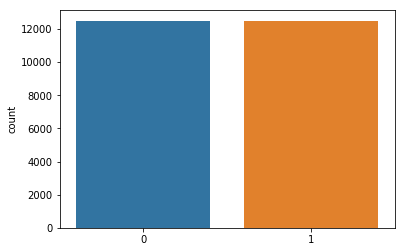

In [37]:
sns.countplot(y)

**ValueError: Floating point image RGB values must be in the 0..1 range.**

if X,y = read_and_process_image(preprocess=True)

```X[0, :,:,::-1]```

```
array([[[-41.68     , -20.779    ,  -7.939003 ],
        [-28.68     ,  -8.778999 ,  12.060997 ],
        [-26.68     ,  -5.7789993,   8.060997 ],
... ...
```

In [38]:
def show_image(X,idx):
    plt.figure(figsize=(10,5), frameon=True)
    img = X[idx, :, :, ::-1]
    img = img/255
    plt.imshow(img)
    plt.show()

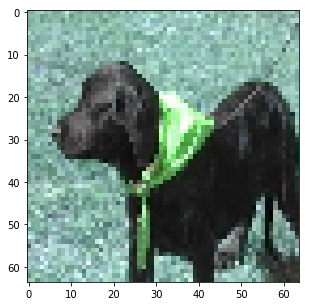

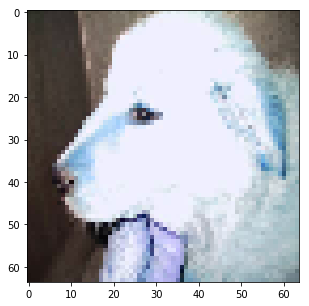

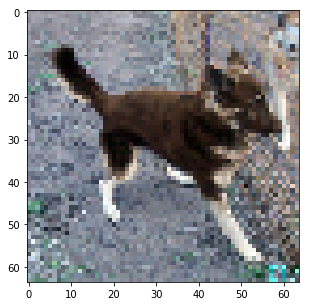

In [39]:
for idx in range(3):
    show_image(X,idx)

 # 3. Modeling - CNN

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3)

In [41]:
model = Sequential()
model.add(Conv2D(32, 3, input_shape=(64,64,3), activation='relu', padding='same'))
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), batch_size=256, epochs=20, verbose=1)

Train on 16666 samples, validate on 8334 samples
Epoch 1/20
16666/16666 [==============================] - 18s 1ms/step - loss: 0.7860 - acc: 0.5350 - val_loss: 0.6790 - val_acc: 0.5397
Epoch 2/20
16666/16666 [==============================] - 14s 860us/step - loss: 0.6566 - acc: 0.6148 - val_loss: 0.6277 - val_acc: 0.6561
Epoch 3/20
16666/16666 [==============================] - 14s 866us/step - loss: 0.6236 - acc: 0.6533 - val_loss: 0.5881 - val_acc: 0.6891
Epoch 4/20
16666/16666 [==============================] - 15s 871us/step - loss: 0.5750 - acc: 0.7041 - val_loss: 0.5803 - val_acc: 0.6944
Epoch 5/20
16666/16666 [==============================] - 15s 871us/step - loss: 0.5282 - acc: 0.7393 - val_loss: 0.4900 - val_acc: 0.7636
Epoch 6/20
16666/16666 [==============================] - 15s 872us/step - loss: 0.4740 - acc: 0.7760 - val_loss: 0.4319 - val_acc: 0.8000
Epoch 7/20
16666/16666 [==============================] - 14s 862us/step - loss: 0.4424 - acc: 0.7999 - val_loss: 0.453

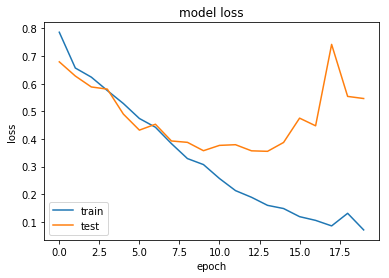

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

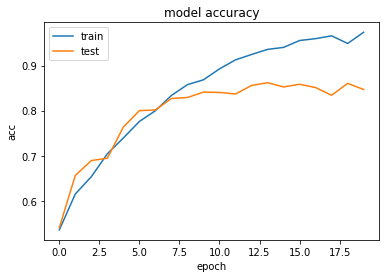

In [44]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc='best')

# 4. Modeling - Pre-trained VGG16

In [2]:
def read_and_process_image(width=224, height=224, channels=3, preprocess=False):
    train_images = ['/kaggle/input/train/'+i for i in os.listdir('/kaggle/input/train/')]
    random.shuffle(train_images)
    
    def read_image(file_path, preprocess):
        img = image.load_img(file_path, target_size=(height,width)) # read and resize to target_size
        x = image.img_to_array(img) # to numpy array by using keras.preprocessing.image
        x = np.expand_dims(x, axis=0) # x.shape(2,2,2) -> x.shape(1,2,2,2)
        if preprocess:     # 对于VGG模型，图片需要每个颜色通道减去每个通道的平均值
            x = preprocess_input(x) # keras.applications.vgg16.preprocess_input
        return x
    
    def prep_data(images, preprocess):
        count = len(images)
        data = np.ndarray((count, height, width, channels), dtype=np.uint8) ##dtype??????????
        for i, img_file in enumerate(images):
            image = read_image(img_file, preprocess)
            data[i] = image
        return data
    
    def read_labels(file_path):
        # dog = 1, cat = 0
        labels = []
        for i in train_images:
            if 'dog' in i:
                labels.append(1)
            else: labels.append(0)
        return labels
    
    X = prep_data(train_images, preprocess)
    labels = read_labels(train_images)
    print("Train shape: {}".format(X.shape))

    return X, labels       

In [3]:
X,y = read_and_process_image()

Train shape: (25000, 224, 224, 3)


In [4]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

In [5]:
train_X.shape

(17500, 224, 224, 3)

In [22]:
# def vgg16_model(input_shape=(224,224,3)):
#     vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
      # include_top=False, do not use VGG16's fully connected layers, instaed, make it directly below 
#     for layer in vgg16.layers:
#         layer.trainable = False
#     last = vgg16.output # VGG16's last layer before connect to fully connected layer
    
#     x = Flatten()(last)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     X = Dense(1, activation='sigmoid')(x)
    
#     model = Model(inputs=vgg16.input, outputs=x)
#     return model
    
def vgg16_model(input_shape = (224, 224, 3)):
    vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)

    for layer in vgg16.layers:
        layer.trainable = False

    last = vgg16.output
    
    #Please modify this part to fill your own fully connected layers.
    x = Flatten()(last)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    
    return model

In [23]:
model_vgg16 = vgg16_model()

In [24]:
model_vgg16.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [25]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
# history = model_vgg16.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=256, epochs=20)
history = model_vgg16.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 20, batch_size = 64)


Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 236s 14ms/step - loss: 1.1227 - acc: 0.8962 - val_loss: 0.3198 - val_acc: 0.9672
Epoch 2/20
17500/17500 [==============================] - 226s 13ms/step - loss: 0.5263 - acc: 0.9487 - val_loss: 0.2481 - val_acc: 0.9723
Epoch 3/20
17500/17500 [==============================] - 226s 13ms/step - loss: 0.3097 - acc: 0.9614 - val_loss: 0.1750 - val_acc: 0.9712
Epoch 4/20
17500/17500 [==============================] - 226s 13ms/step - loss: 0.1866 - acc: 0.9689 - val_loss: 0.1385 - val_acc: 0.9719
Epoch 5/20
17500/17500 [==============================] - 227s 13ms/step - loss: 0.1416 - acc: 0.9723 - val_loss: 0.1450 - val_acc: 0.9721
Epoch 6/20
17500/17500 [==============================] - 227s 13ms/step - loss: 0.1008 - acc: 0.9779 - val_loss: 0.1286 - val_acc: 0.9724
Epoch 7/20
17500/17500 [==============================] - 227s 13ms/step - loss: 0.0942 - acc: 0.9803 - val_loss: 0.1

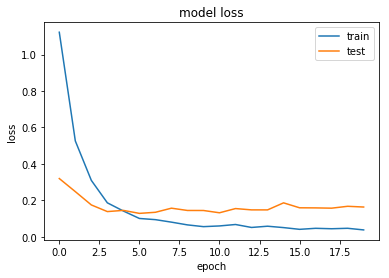

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

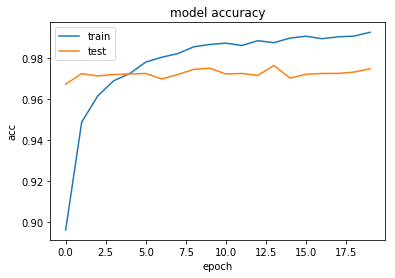

In [28]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc='best')